In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.notebook_repr_html', False)

act = pd.read_csv('OTg6QzA_activities.csv') #불러온 파일 이름이 act
act.shape # 데이터 구조, 행열 크기 알아보기

(66281, 4)

In [3]:
# 거리 및 속도 산출을 위해, 직전 데이터(t-1)를 새로운 열에 추가함
# shift(1)로 timestamp열값이 하나씩 아래로 이동된다.
act['p_timestamp'] = act['timestamp'].shift(1) # timestamp의 값을 p_timestamp에 한칸씩 밀어서 저장
act['p_x'] = act['X'].shift(1) # X의 값을 p_x에 한칸씩 밀어서 저장
act['p_y'] = act['Y'].shift(1) # Y도 동일하게
act['p_z'] = act['Z'].shift(1) # Z도 동일하게
act.head(5) # 불러온 데이터에서 한칸씩 시프트한 열을 추가

                 timestamp   X   Y   Z              p_timestamp   p_x   p_y  \
0  2022-01-01 00:01:40.363  33  76  56                     None   NaN   NaN   
1  2022-01-01 00:01:42.961  34  87  56  2022-01-01 00:01:40.363  33.0  76.0   
2  2022-01-01 00:01:45.562  25  89  47  2022-01-01 00:01:42.961  34.0  87.0   
3  2022-01-01 00:01:48.163  11  70  50  2022-01-01 00:01:45.562  25.0  89.0   
4  2022-01-01 00:02:08.864  33  72  58  2022-01-01 00:01:48.163  11.0  70.0   

    p_z  
0   NaN  
1  56.0  
2  56.0  
3  47.0  
4  50.0  

In [4]:
cleaned = act.dropna() # shift하면서 생긴 NaN이 있는 1행을 제거, cleaned는 데이터를 불러온 act에서 shift한뒤 p_timestamp, p_x, p_y, p_z열이 추가된 상태에서 1행 NaN을 지운 데이터

In [5]:
# 두 지점 간의 거리차이를 dist 열에 추가

# 거리 계산 함수
def calc_dist(df):
  x_d = df['X'] - df['p_x'] # x 변화량
  y_d = df['Y'] - df['p_y'] # y 변화량
  z_d = df['Z'] - df['p_z'] # z 변화량
  return np.sqrt(x_d**2 + y_d**2 + z_d**2)  #지금과 이전 좌표의 거리차이

cleaned.loc[:,'dist'] = cleaned.loc[:, ['X','p_x', 'Y', 'p_y', 'Z', 'p_z']].apply(calc_dist, axis=1)

C:\Users\302-1\AppData\Local\Temp\ipykernel_10216\2254831757.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.loc[:,'dist'] = cleaned.loc[:, ['X','p_x', 'Y', 'p_y', 'Z', 'p_z']].apply(calc_dist, axis=1)


In [6]:
# 포인트간 시간차이을, d_time 열에 저장
from datetime import datetime

# 시간차이 구하는 함수
def calc_timediff(df):
  d1 = datetime.strptime(df['timestamp'], "%Y-%m-%d %H:%M:%S.%f") # 기존 데이터
  d2 = datetime.strptime(df['p_timestamp'], "%Y-%m-%d %H:%M:%S.%f") # 기존데이터에서 1칸 shift한것
  return (d1 - d2).total_seconds()

cleaned['d_time'] = cleaned[["timestamp","p_timestamp"]].apply(calc_timediff, axis=1) # cleaned 데이터에 새로운 d_time에 저장

C:\Users\302-1\AppData\Local\Temp\ipykernel_10216\3471971512.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['d_time'] = cleaned[["timestamp","p_timestamp"]].apply(calc_timediff, axis=1) # cleaned 데이터에 새로운 d_time에 저장


In [7]:
# 지금까지 근접 2개 좌표를 이용해서 구한 거리차이리, 시간차이을 이용해서 속도=거리/시간, 속도를 구하자

# 속도 함수
def calc_act(df):
  if df['d_time'] != 0: #시간차이가 0이 아닐때만, act는 시간에따라 x,y,z 측정. 시간은 0이 아닐수밖에 없다
    return np.abs(df['dist'] / df['d_time']) # 리턴값(속도) = 거리/시간
  else:
    return 0

cleaned['calc_act'] = cleaned[["dist", "d_time"]].apply(calc_act, axis=1) # cleaned에서 구한 dist(거리차이)와 d_time 시간차이를 인자로 전달, return calc_act를 cleaned에 'calc_act'라는 이름의 열에 저장

C:\Users\302-1\AppData\Local\Temp\ipykernel_10216\3029486389.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['calc_act'] = cleaned[["dist", "d_time"]].apply(calc_act, axis=1) # cleaned에서 구한 dist(거리차이)와 d_time 시간차이를 인자로 전달, return calc_act를 cleaned에 'calc_act'라는 이름의 열에 저장


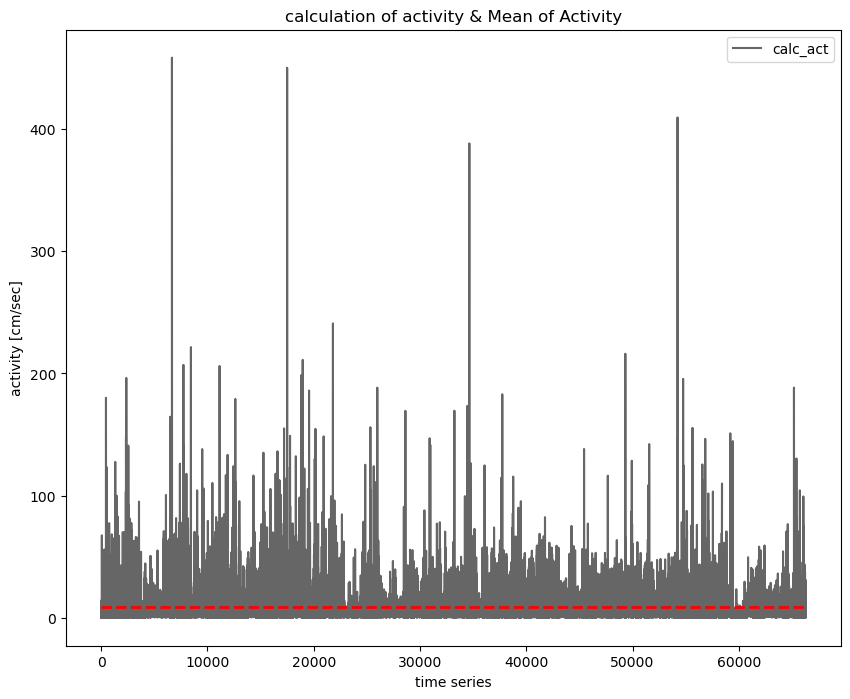

In [8]:
plt.rcParams['figure.figsize'] = [10, 8] # 그래프 사이즈 설정, (가로 10인치, 세로 8인치)
cleaned.plot(y="calc_act", color="0.4", title="calculation of activity & Mean of Activity", ylabel="activity [cm/sec]", xlabel="time series")
plt.hlines(cleaned['calc_act'].mean(),  min(cleaned.index), max(cleaned.index),  color='Red', linestyle='--', linewidth=2)